In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

import temp_crt


plt.rcParams['figure.figsize'] = [5, 3]
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.constrained_layout.use'] = True

# py.offline.init_notebook_mode(connected=True)

In [26]:
# parse the letter 'D' (mocap data)
traj = temp_crt.parse_trajectory("D")
strokes = traj[0]
#print(strokes)
t = strokes[0]
x = strokes[1]
y = strokes[2]
stroke1 = strokes[:, 0:31]  # Y = -0.34639319
np.savetxt("stroke1.csv", np.transpose(stroke1), delimiter=",")
stroke2 = strokes[:, 31:57] # X = 0.74592703
np.savetxt("stroke2.csv", np.transpose(stroke2), delimiter=",")
stroke3 = strokes[:, 57::] # to end
np.savetxt("stroke3.csv", np.transpose(stroke3), delimiter=",")
#print(np.transpose(stroke1))
#print(" ")
#print(np.transpose(stroke2))
#print(" ")
#print(np.transpose(stroke3))

stroke1_nt = np.array([x[0:31],y[0:31]])
#print(stroke1_nt)
velocity = np.sqrt(np.sum((np.gradient(stroke1_nt, axis=1)/0.008333)**2,
                                  axis=0))
#print(velocity)

# Import csv file (gtsam result)
file = open('stroke1_005_60.csv')
columns = ["time", "x", "y"]
dex = pd.read_csv("stroke1_005_60.csv", usecols=columns)
tex = dex.time.tolist()
xex = dex.x.tolist()
yex = dex.y.tolist()
velocity2 = np.sqrt(np.sum((np.gradient(np.array([xex,yex]), axis=1)/0.0042)**2,
                                  axis=0))
#print(velocity2)

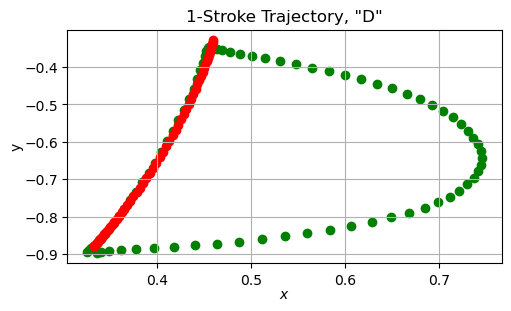

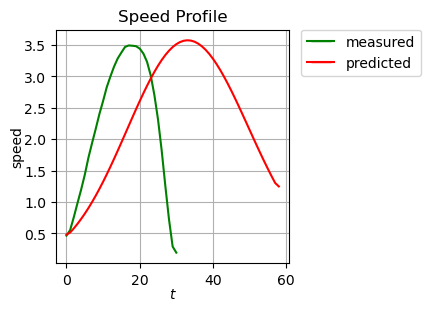

In [18]:
# Plotting
blk_ln = mlines.Line2D([], [], color='black', marker='_',
                       markersize=15, label='measured')
green_pt = mlines.Line2D([], [], color='green', marker='_',
                         markersize=15, label='measured')
red_pt = mlines.Line2D([], [], color='red', marker='_',
                       markersize=15, label='predicted')
yellow_ln = mlines.Line2D([], [], color='yellow', marker='_',
                          markersize=15, label='error')

fig, ax = plt.subplots()
plt.title('1-Stroke Trajectory, "D"')
plt.grid(visible=1)
plt.scatter(x, y, c='g')
plt.scatter(xex, yex, c='r')
#plt.scatter(xre, yre, c='r')
plt.xlabel('$x$', labelpad=0)
plt.ylabel('y', labelpad=0)

fig, ax = plt.subplots()
plt.title('Speed Profile')
plt.grid(visible=1)
# for i, s in enumerate(strokes):
#     plt.fill_between(t, 0, s, where=s > 0, facecolor='grey', alpha=0.5)
plt.plot(velocity, 'g')
plt.plot(velocity2, 'r')
# plt.scatter(tm, v, c='g')
# plt.scatter(tm, V, c='r')
# for i in range(len(px)):
#     lineXdata = (tm[i], tm[i])  # same X
#     lineYdata = (v[i], V[i])  # different Y
#     plt.plot(lineXdata, lineYdata, c='y')
plt.xlabel('$t$', labelpad=0)
plt.ylabel('speed', labelpad=0)
ax.set_box_aspect(1)
plt.legend(handles=[green_pt, red_pt],
           bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [19]:
# plt.scatter(px, py, c='g')
# plt.scatter(Xx, Xy, c='r')
# for i in range(len(px)):
#     lineXdata = (px[i], px[i])  # same X
#     lineYdata = (py[i], Xy[i])  # different Y
#     plt.plot(lineXdata, lineYdata, c='y')
# plt.xlabel('$x$', labelpad=0)
# plt.ylabel('y', labelpad=0)
# ax.set_box_aspect(1)
# plt.legend(handles=[blk_ln, green_pt, red_pt],
#            bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# fig, axs = plt.subplots(2, sharex=True)
# fig.suptitle('X and Y vs Time')
# axs[0].grid()
# axs[0].scatter(tm, px, c='g')
# axs[0].scatter(tm, Xx, c='r')
# for i in range(len(px)):
#     lineXdata = (tm[i], tm[i])  # same X
#     lineYdata = (px[i], Xx[i])  # different Y
#     axs[0].plot(lineXdata, lineYdata, c='y')
# axs[0].set(xlabel='$t$', ylabel='x')
# axs[1].grid()
# axs[1].scatter(tm, py, c='g')
# axs[1].scatter(tm, Xy, c='r')
# for i in range(len(py)):
#     lineXdata = (tm[i], tm[i])  # same X
#     lineYdata = (py[i], Xy[i])  # different Y
#     axs[1].plot(lineXdata, lineYdata, c='y')
# axs[1].set(xlabel='$t$', ylabel='y')
# plt.legend(handles=[green_pt, red_pt, yellow_ln],
#            loc='right')

# fig, ax = plt.subplots()
# plt.title('Speed Profile')
# plt.grid(visible=1)
# for i, s in enumerate(strokes):
#     plt.fill_between(t, 0, s, where=s > 0, facecolor='grey', alpha=0.5)
# plt.plot(t, velocity, 'k')
# plt.scatter(tm, v, c='g')
# plt.scatter(tm, V, c='r')
# for i in range(len(px)):
#     lineXdata = (tm[i], tm[i])  # same X
#     lineYdata = (v[i], V[i])  # different Y
#     plt.plot(lineXdata, lineYdata, c='y')
# plt.xlabel('$t$', labelpad=0)
# plt.ylabel('speed', labelpad=0)
# ax.set_box_aspect(1)
# plt.legend(handles=[blk_ln, green_pt, red_pt, yellow_ln],
#            bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)